In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import color_mask, dilate, erode, opening, closing, external_border

In [ ]:
SIZE_SQUARE = 30
NB_FRAMES_FREE = 25

range_white = 45

lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
upper_white = [min(240, c + range_white) for c in WHITE_CHESS]

pink_sticker = [255, 59, 155]  
blue_sticker = [44, 163, 227]

range_pink = 45         
range_blue = 45

lower_pink = [max(0, c - range_pink) for c in pink_sticker]
upper_pink = [min(255, c + range_pink) for c in pink_sticker] 
lower_blue = [max(0, c - range_blue) for c in blue_sticker] 
upper_blue = [min(255, c + range_blue) for c in blue_sticker] 

"""
Custom YOLO train over Roboflow dataset on corner of chessboard
"""
model = YOLO(r'..\weights\best.pt')
model2 = YOLO(r'..\weights\best11m.pt')

# !!!!! not use  mov, doesnt work, convert to avi
video_path = r'..\video\IMG_0485.avi'

In [ ]:
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error opening the video file")
    exit()
else:
    # Get frame rate information
    fps = int(cap.get(5))
    print("Frame Rate : ",fps,"frames per second")  
    
    # Get frame count, if you see -1, the video is not good
    frame_count = cap.get(7)
    print("Frame count : ", frame_count)



corner_1_centers = []
corner_2_centers = []
corner_3_centers = []
corner_4_centers = []

corner_init_guess = []

frame_idx = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break  # Exit loop if no frames are returned (end of video)

    results = model.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()

            # Center of the bounding box
            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  

            # Determine which corner the center belongs to
            if cx < frame.shape[1] / 2 and cy < frame.shape[0] / 2:
                corner_4_centers.append((cx, cy))
                
            elif cx >= frame.shape[1] / 2 and cy < frame.shape[0] / 2:
                corner_3_centers.append((cx, cy))

            elif cx < frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
                corner_2_centers.append((cx, cy))

            elif cx >= frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
                corner_1_centers.append((cx, cy))

    frame_idx += 1

    if frame_idx >= NB_FRAMES_FREE:
        corner_init_guess = [
            np.mean(corner_1_centers, axis=0),
            np.mean(corner_2_centers, axis=0),
            np.mean(corner_3_centers, axis=0),
            np.mean(corner_4_centers, axis=0),

        ]

        cv2.circle(frame, (int(corner_init_guess[0][0]), int(corner_init_guess[0][1])), 7, BLUE, -1)
        cv2.circle(frame, (int(corner_init_guess[1][0]), int(corner_init_guess[1][1])), 7, BLUE, -1)
        cv2.circle(frame, (int(corner_init_guess[2][0]), int(corner_init_guess[2][1])), 7, BLUE, -1)
        cv2.circle(frame, (int(corner_init_guess[3][0]), int(corner_init_guess[3][1])), 7, BLUE, -1)

        # draw squares using corner_init_guess
        for i in range(4):
            cx, cy = corner_init_guess[i]
            x1 = cx - SIZE_SQUARE / 2
            y1 = cy - SIZE_SQUARE / 2
            x2 = cx + SIZE_SQUARE / 2
            y2 = cy + SIZE_SQUARE / 2
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), GREEN, 2)

        # Display the frame with annotations in an external window
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame {frame_idx}')
        plt.show()

        break

xh8 (None, None)
yh8 (None, 1281.9120483398438)
xh1 (1281.9120483398438, 341.45166015625)
yh1 (341.45166015625, 242.75101470947266)


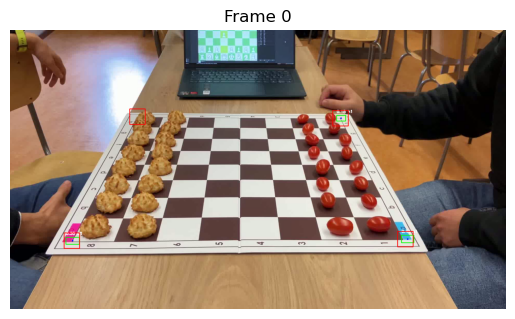

xh8 (None, None)
yh8 (None, 1283.8816528320312)
xh1 (1283.8816528320312, 341.3921661376953)
yh1 (341.3921661376953, 242.8453598022461)


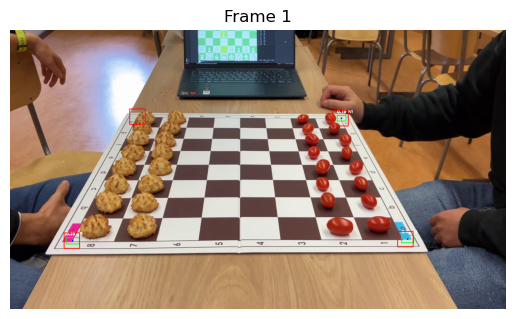

xh8 (None, None)
yh8 (None, 1283.3653564453125)
xh1 (1283.3653564453125, 341.29151916503906)
yh1 (341.29151916503906, 241.69525146484375)


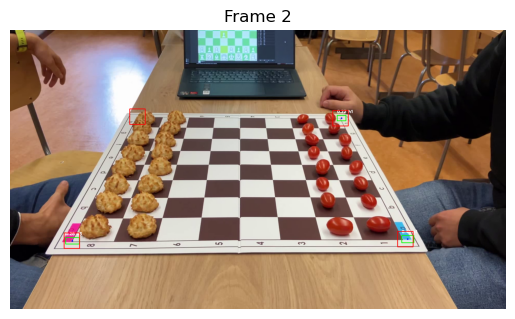

In [19]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_idx = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break  # Exit loop if no frames are returned (end of video)

    results = model.track(source=frame, persist=True, show=False, tracker="bytetrack.yaml")

    # Initialize corner coordinates
    corners = {
        "xh8": None, "yh8": None,
        "xh1": None, "yh1": None,
        "xa8": None, "ya8": None,
        "xa1": None, "ya1": None
    }

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            class_id = box.cls[0].item()
            label = model.names[int(class_id)]
            label_text = f"{confidence:.2f}"

            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # Center of the bounding box

            # Determine which corner the center belongs to
            if cx < frame.shape[1] / 2 and cy < frame.shape[0] / 2:
                corners["xh8"], corners["yh8"] = cx, cy
                label_text += " h8"
                if frame_idx < NB_FRAMES_FREE:
                    corner_4_centers.append((cx, cy))
                
            elif cx >= frame.shape[1] / 2 and cy < frame.shape[0] / 2:
                corners["xh1"], corners["yh1"] = cx, cy
                label_text += " h1"
                if frame_idx < NB_FRAMES_FREE:
                    corner_3_centers.append((cx, cy))
            elif cx < frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
                corners["xa8"], corners["ya8"] = cx, cy
                label_text += " a8"
                if frame_idx < NB_FRAMES_FREE:
                    corner_2_centers.append((cx, cy))
            elif cx >= frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
                corners["xa1"], corners["ya1"] = cx, cy
                label_text += " a1"
                if frame_idx < NB_FRAMES_FREE:
                    corner_1_centers.append((cx, cy))

            cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), GREEN, 2)
            cv2.putText(frame, label_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

    if frame_idx == NB_FRAMES_FREE:
        corner_init_guess = [
            np.mean(corner_1_centers, axis=0),
            np.mean(corner_2_centers, axis=0),
            np.mean(corner_3_centers, axis=0),
            np.mean(corner_4_centers, axis=0),
        ]

    if corner_init_guess:
        for (x, y) in corner_init_guess:
            top_left = (int(x - SIZE_SQUARE), int(y - SIZE_SQUARE))
            bottom_right = (int(x + SIZE_SQUARE), int(y + SIZE_SQUARE))
            cv2.rectangle(frame, top_left, bottom_right, RED, 2)

    # Print corner coordinates
    corners_names = list(corners.keys())
    corners_values = list(corners.values())
    for i in range(len(corners_names)//2):
        print(f"{corners_names[i]} ({corners_values[i]}, {corners_values[i+1]})")

    for corner, coord in corners.items():
        if coord is not None:
            if frame_idx < NB_FRAMES_FREE:
                if all(corners.values()):
                        pts = np.array([
                            [corners["xh8"], corners["yh8"]],
                            [corners["xh1"], corners["yh1"]],
                            [corners["xa1"], corners["ya1"]],
                            [corners["xa8"], corners["ya8"]]
                        ], np.int32)
            
            elif frame_idx >= NB_FRAMES_FREE:
                # Draw polygon if all corners are available
                if all(corners.values()):
                    pts = np.array([
                        [corners["xh8"], corners["yh8"]],
                        [corners["xh1"], corners["yh1"]],
                        [corners["xa1"], corners["ya1"]],
                        [corners["xa8"], corners["ya8"]]
                    ], np.int32)
                else:
                    pts = np.array([
                        corner_init_guess[3] if corners["xh8"] is None else [corners["xh8"], corners["yh8"]],
                        corner_init_guess[2] if corners["xh1"] is None else [corners["xh1"], corners["yh1"]],
                        corner_init_guess[0] if corners["xa1"] is None else [corners["xa1"], corners["ya1"]],
                        corner_init_guess[1] if corners["xa8"] is None else [corners["xa8"], corners["ya8"]]
                    ], np.int32)

                pts = pts.reshape((-1, 1, 2))
                cv2.polylines(frame, [pts], isClosed=True, color=RED, thickness=2)

    # Display the frame with annotations in an external window
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {frame_idx}')
    plt.axis('off')
    plt.show()

    frame_idx += 1

    if frame_idx >= 3:
        break

# Release the video capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()